In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [13]:
class CustomSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.last_attn_weights = None

    def forward(self, x, mask=None, src_key_padding_mask=None):
        attn_output, attn_weights = self.multihead_attn(
            x, x, x,
            attn_mask=mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True
        )
        self.last_attn_weights = attn_weights
        return attn_output

class ToyTransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Usa la nostra implementazione personalizzata di self-attention
        self.self_attn = CustomSelfAttention(embed_dim, num_heads)

        # Crea un feedforward layer simile a quello nel TransformerEncoderLayer
        self.linear1 = nn.Linear(embed_dim, embed_dim * 4)
        self.linear2 = nn.Linear(embed_dim * 4, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len, embed_dim]
        x = x.permute(1, 0, 2)  # [seq_len, batch, embed_dim]

        # Implementa manualmente un TransformerEncoderLayer
        # Self attention block
        residual = x
        x = self.self_attn(x)
        x = x + residual
        x = self.norm1(x)

        # Feedforward block
        residual = x
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = x + residual
        x = self.norm2(x)

        # Pooling e classificazione
        x = x.mean(dim=0)
        logits = self.classifier(x)
        return torch.sigmoid(logits)

    @property
    def attention_maps(self):
        return self.self_attn.last_attn_weights

Definiamo una funzione di plotting per la mappa di attenzione

In [24]:
def plot_attention(attn, title="Attention Map"):
    # Detach per rimuovere il calcolo del gradiente prima della conversione a NumPy
    attn = attn.detach()

    num_heads = attn.shape[0]
    for h in range(num_heads):
        plt.imshow(attn[h].cpu(), cmap='viridis')
        plt.title(f"{title} - Head {h}")
        plt.xlabel("Key (input token idx)")
        plt.ylabel("Query (input token idx)")
        plt.colorbar()
        plt.show()

# Estrazione mappe

In [21]:
# Input finto: batch di 2 sequenze
input_ids = torch.tensor([[1, 2, 3, 4, 0], [5, 6, 7, 8, 9]])
batch_size = input_ids.shape[0]  # 2
seq_len = input_ids.shape[1]     # 5
model = ToyTransformerClassifier()
output = model(input_ids)

# Verifica la dimensione effettiva del tensore di attenzione
attention_size = model.attention_maps.numel()
print(f"Dimensione effettiva delle attention maps: {attention_size}")
print("Prediction (sigmoid output):", output)
print("Shape delle attention maps:", model.attention_maps.shape)  # [batch*num_heads, tgt_len, src_len]

# Calcola il numero di teste dall'attention_size
calculated_num_heads = attention_size // (batch_size * seq_len * seq_len)
print(f"Numero di teste calcolato: {calculated_num_heads}")

# Esegui il reshape corretto
attn_maps = model.attention_maps.view(batch_size, calculated_num_heads, seq_len, seq_len)



Dimensione effettiva delle attention maps: 50
Prediction (sigmoid output): tensor([[0.4772],
        [0.4495]], grad_fn=<SigmoidBackward0>)
Shape delle attention maps: torch.Size([2, 5, 5])
Numero di teste calcolato: 1


Plotting della mappa di attenzione

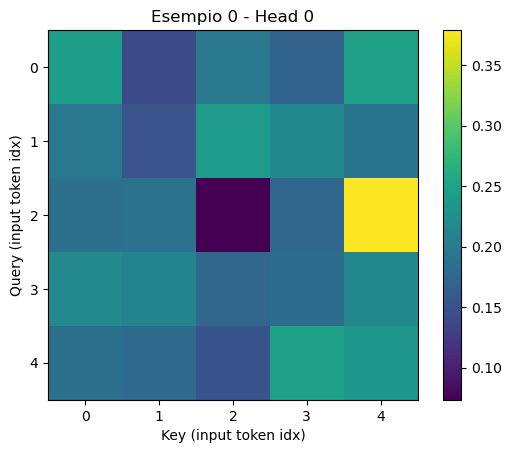

In [25]:
# Visualizza per il primo esempio nel batch
plot_attention(attn_maps[0], title="Esempio 0")

## 🧠 Cos’è una mappa di attenzione?

Quella che vedi è una matrice di attenzione per un singolo head di un transformer encoder. È una matrice quadrata perché ogni token può "guardare" (attendere) tutti gli altri, incluso sé stesso.

Assi:
- Y (riga) → il token Query, cioè quello che sta "attendendo".

- X (colonna) → il token Key, cioè quello a cui il token sta prestando attenzione.

## 🔍 Interpretazione pratica

Prendiamo l’esempio concreto che hai visualizzato:

- La dimensione è 5×5 → quindi ci sono 5 token in input (inclusi padding, se presenti).

- Il colore indica il peso di attenzione: più è chiaro/verde, più alta è l’attenzione che un token (sulla riga) dedica a un altro token (sulla colonna).

- Ad esempio, il colore molto chiaro in [2,4] significa che il token 2 "attende" molto il token 4.

- Il colore rosa pallido in [2,2] indica che il token 2 presta poca attenzione a sé stesso.


## 💡 Esempio interpretativo

Immaginiamo che i token siano l'embedding della frase `I love deep learning models`, con `ID[1,2,3,4,0]` dove lo zero è di padding. La mappa potrebbe indicare:
1. Il token "deep" (idx 2) guarda molto "models" (idx 4),

2. "love" (idx 1) guarda soprattutto "deep" (idx 2),

3. "I" (idx 0) ha un’attenzione distribuita su tutti.